In [2]:
import pandas as pd
import numpy as np
import ast
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import joblib
import dataframe_image as dfi



In [5]:
# Replace with the path to your cleaned CSV file
data_file = '/Users/paxpoggi/Library/Mobile Documents/com~apple~CloudDocs/Documents/Maier Lab/IIT Notebooks/Cleaned Graph Data/parsed_probe_data.csv'

# Load the data
df = pd.read_csv(data_file)

# Display the first few rows
print(df.head())

# # Replace 'natural_move_one' and 'natural_move_three' with 'natural_movie' to merge categories
# df['presentation_type'] = df['presentation_type'].replace({
#     'natural_move_one': 'natural_movie',
#     'natural_move_three': 'natural_movie'
# })

print(df['presentation_type'].unique())


        probe_name visual_area presentation_type  interval_start  \
0  probe_773463015       VISam           flashes               1   
1  probe_773463015       VISam           flashes              51   
2  probe_773463015       VISam           flashes             101   
3  probe_773463015       VISam           flashes             151   
4  probe_773463015       VISam   static_gratings               1   

   interval_end   max_phi max_phi_state  total_distinctions  \
0            50  4.504989     [1, 1, 1]                   7   
1           100  3.755319     [0, 0, 0]                   7   
2           150  3.590710     [1, 1, 1]                   7   
3           200  3.444718     [0, 0, 1]                   7   
4            50  3.429473     [1, 0, 0]                   7   

   total_integrated_information_distinctions  total_cause_information  \
0                                   1.766300                 4.503652   
1                                   1.637070                 4.328

In [6]:
# Convert string representation of lists into actual lists
df['max_phi_state'] = df['max_phi_state'].apply(ast.literal_eval)

# Expand the list into separate columns
max_phi_state_df = df['max_phi_state'].apply(pd.Series)
max_phi_state_df.columns = ['max_phi_state_1', 'max_phi_state_2', 'max_phi_state_3']

# Drop the original 'max_phi_state' column and concatenate the new columns
df = pd.concat([df.drop('max_phi_state', axis=1), max_phi_state_df], axis=1)

# Use LabelEncoder for 'visual_area'
le_visual_area = LabelEncoder()
df['visual_area_encoded'] = le_visual_area.fit_transform(df['visual_area'])

# Optionally, drop the original 'visual_area' column
df = df.drop('visual_area', axis=1)

le_presentation_type = LabelEncoder()
df['presentation_type_encoded'] = le_presentation_type.fit_transform(df['presentation_type'])


In [7]:
# Define feature columns
feature_cols = [
    'interval_start', 'interval_end', 'max_phi',
    'total_distinctions', 'total_integrated_information_distinctions',
    'total_cause_information', 'total_effect_information', 'total_relations',
    'total_integrated_information_relations', 'faces_1_9', 'faces_10_30',
    'faces_30_plus', 'visual_area_encoded',
    'max_phi_state_1', 'max_phi_state_2', 'max_phi_state_3'
]

# Define X and y
X = df[feature_cols]
y = df['presentation_type_encoded']

# Get class names for future reference
class_names = le_presentation_type.classes_

# Print the mapping of classes to encoded labels
label_mapping = dict(zip(le_presentation_type.classes_, le_presentation_type.transform(le_presentation_type.classes_)))
print("Label Mapping:", label_mapping)


Label Mapping: {'flashes': np.int64(0), 'gabors': np.int64(1), 'natural_move_one': np.int64(2), 'natural_move_three': np.int64(3), 'natural_scenes': np.int64(4), 'static_gratings': np.int64(5)}


In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [9]:
# Initialize the scaler
scaler = StandardScaler()

# Fit on training data and transform both training and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [32]:
# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],              # Regularization parameter
    'gamma': ['scale', 'auto', 0.01, 0.001, 0.0001],  # Kernel coefficient
    'kernel': ['rbf', 'poly', 'sigmoid'] # Kernel type
}


In [33]:
# Create a base model
svm = SVC(random_state=42)

# Set up the grid search
grid_search = GridSearchCV(
    estimator=svm,
    param_grid=param_grid,
    cv=3,                # 3-fold cross-validation
    n_jobs=-1,           # Use all available cores
    verbose=2,
    scoring='accuracy'
)

# Fit the grid search to the data
grid_search.fit(X_train_scaled, y_train)

print(f"Best hyperparameters: {grid_search.best_params_}")


Fitting 3 folds for each of 60 candidates, totalling 180 fits
[CV] END ....................C=0.1, gamma=scale, kernel=poly; total time=   0.4s
[CV] END ....................C=0.1, gamma=scale, kernel=poly; total time=   0.5s
[CV] END ....................C=0.1, gamma=scale, kernel=poly; total time=   0.5s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.7s
[CV] END .................C=0.1, gamma=scale, kernel=sigmoid; total time=   0.7s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.8s
[CV] END .................C=0.1, gamma=scale, kernel=sigmoid; total time=   0.8s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.8s
[CV] END .................C=0.1, gamma=scale, kernel=sigmoid; total time=   0.7s
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time=   0.7s
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time=   0.7s
[CV] END .....................C=0.1, gamma=auto

In [34]:
# Get the best model
best_svm = grid_search.best_estimator_

# Predict on the test set
y_pred_best = best_svm.predict(X_test_scaled)

# Evaluate the model
print(classification_report(y_test, y_pred_best, target_names=class_names))


                 precision    recall  f1-score   support

        flashes       0.76      0.63      0.69       228
         gabors       0.36      0.21      0.27       228
  natural_movie       0.60      0.90      0.72       456
 natural_scenes       0.34      0.23      0.27       228
static_gratings       0.50      0.47      0.49       228

       accuracy                           0.56      1368
      macro avg       0.51      0.49      0.49      1368
   weighted avg       0.53      0.56      0.53      1368



In [35]:
# save best model to folder
folder = '/Users/paxpoggi/Library/Mobile Documents/com~apple~CloudDocs/Documents/Maier Lab/IIT Notebooks/Models/'
filename = 'best_svm_model_merged_movies.pkl'
# Save the model
joblib.dump(best_svm, folder + filename)

['/Users/paxpoggi/Library/Mobile Documents/com~apple~CloudDocs/Documents/Maier Lab/IIT Notebooks/Models/best_svm_model_merged_movies.pkl']

In [3]:
# load the best model
folder = '/Users/paxpoggi/Library/Mobile Documents/com~apple~CloudDocs/Documents/Maier Lab/IIT Notebooks/Models/'
filename = 'best_svm_model.pkl'
loaded_model = joblib.load(folder + filename)

In [10]:
# create confusion matrix
best_svm = loaded_model
# Predict on the test set
y_pred_best = best_svm.predict(X_test_scaled)
# Evaluate the model
print(classification_report(y_test, y_pred_best, target_names=class_names))
conf_matrix = confusion_matrix(y_test, y_pred_best)

                    precision    recall  f1-score   support

           flashes       0.81      0.60      0.69       228
            gabors       0.35      0.25      0.29       228
  natural_move_one       0.29      0.26      0.28       228
natural_move_three       0.43      0.64      0.51       228
    natural_scenes       0.27      0.30      0.28       228
   static_gratings       0.52      0.52      0.52       228

          accuracy                           0.43      1368
         macro avg       0.44      0.43      0.43      1368
      weighted avg       0.44      0.43      0.43      1368



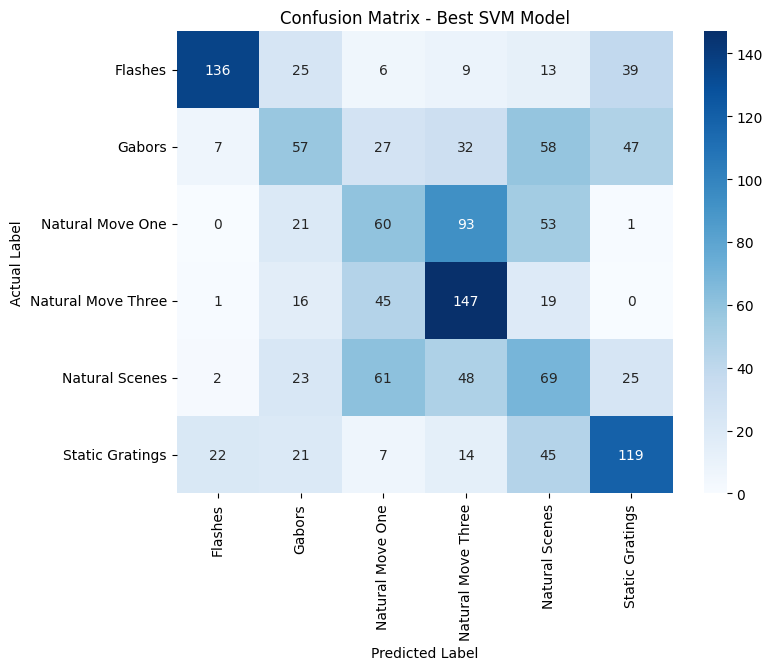

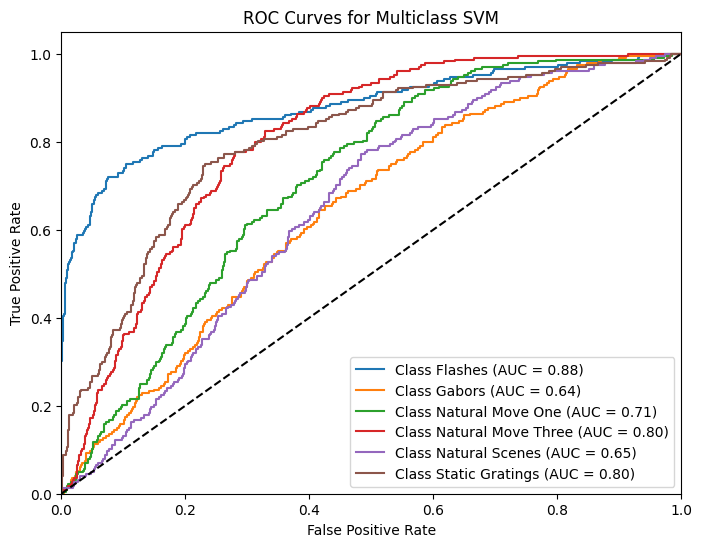

,precision,recall,f1-score,support
Flashes,0.81,0.60,0.69,228.00
Gabors,0.35,0.25,0.29,228.00
Natural Move One,0.29,0.26,0.28,228.00
Natural Move Three,0.43,0.64,0.51,228.00
Natural Scenes,0.27,0.30,0.28,228.00
Static Gratings,0.52,0.52,0.52,228.00
macro avg,0.44,0.43,0.43,1368.00



Per-Class Metrics:
             Class  Accuracy  Precision  Recall  F1-Score  Support
           Flashes    0.5965     0.8095  0.5965    0.6869    228.0
            Gabors    0.2500     0.3497  0.2500    0.2916    228.0
  Natural Move One    0.2632     0.2913  0.2632    0.2765    228.0
Natural Move Three    0.6447     0.4286  0.6447    0.5149    228.0
    Natural Scenes    0.3026     0.2685  0.3026    0.2845    228.0
   Static Gratings    0.5219     0.5152  0.5219    0.5185    228.0


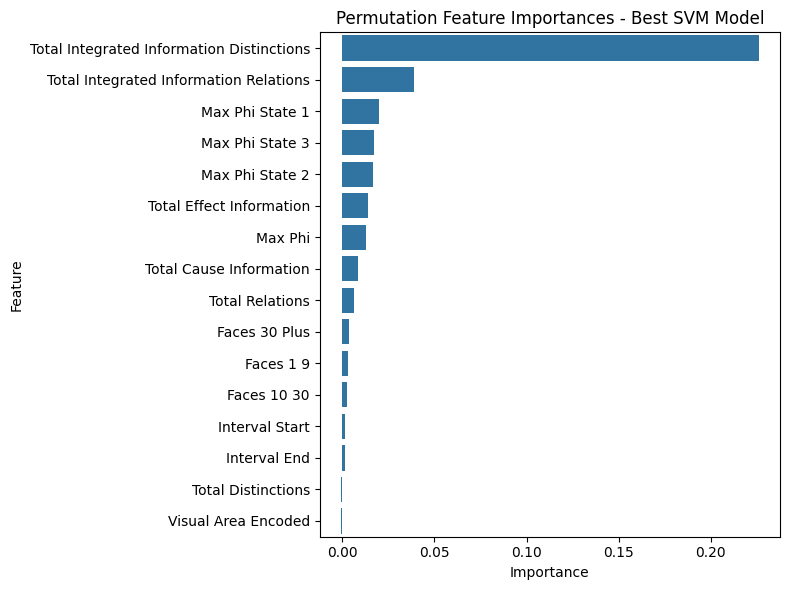

['best_svm_model.pkl']

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.inspection import permutation_importance
import joblib

# Assuming you have 'best_svm', 'X_train_scaled', 'X_test_scaled', 'y_train', 'y_test', 'class_names'

# clean up class names by removing underscores and capitalizing
class_names = [name.replace('_', ' ').title() for name in class_names]

# 1. Confusion Matrix
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Best SVM Model')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# 2. ROC Curves
# Binarize the output
y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_binarized.shape[1]

# Fit the model with OneVsRestClassifier
classifier = OneVsRestClassifier(best_svm)
y_score = classifier.fit(X_train_scaled, y_train).decision_function(X_test_scaled)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(8,6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {class_names[i]} (AUC = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Multiclass SVM')
plt.legend(loc='lower right')
plt.show()

# 3. Table with Accuracies
report = classification_report(y_test, y_pred_best, target_names=class_names, output_dict=True)
report_df = pd.DataFrame(report).transpose()
# Select only class-specific rows and macro avg row
report_df = report_df.loc[list(class_names) + ['macro avg']]
# Style and display the table
styled_report = report_df.style.format(precision=2).set_caption("Classification Report with Macro Average").background_gradient(cmap="Blues", subset=['precision', 'recall', 'f1-score'])
display(styled_report)
folder = '/Users/paxpoggi/Library/Mobile Documents/com~apple~CloudDocs/Documents/Maier Lab/IIT Notebooks/Models/'
dfi.export(styled_report, folder + "classification_report_svm.png")
report_df = report_df.drop(['accuracy', 'macro avg', 'weighted avg'], errors='ignore')
cm = confusion_matrix(y_test, y_pred_best)
per_class_accuracy = cm.diagonal() / cm.sum(axis=1)
report_df['accuracy'] = per_class_accuracy
report_df.reset_index(inplace=True)
report_df.rename(columns={'index': 'Class', 'precision': 'Precision', 'recall': 'Recall',
                          'f1-score': 'F1-Score', 'support': 'Support', 'accuracy': 'Accuracy'}, inplace=True)
report_df = report_df[['Class', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'Support']]
report_df[['Accuracy', 'Precision', 'Recall', 'F1-Score']] = report_df[['Accuracy', 'Precision', 'Recall', 'F1-Score']].round(4)
print("\nPer-Class Metrics:")
print(report_df.to_string(index=False))

# 4. Feature Importance using Permutation Importance
result = permutation_importance(
    best_svm, X_test_scaled, y_test, n_repeats=10, random_state=42, n_jobs=-1
)
importances = result.importances_mean
feature_names = X_train.columns
# clean up the feature names by removing underscores and capitalizing
feature_names = [name.replace('_', ' ').title() for name in feature_names]
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Permutation Feature Importances - Best SVM Model')
plt.tight_layout()
plt.show()

# 5. Save the best model
joblib.dump(best_svm, 'best_svm_model.pkl')
